<a href="https://www.kaggle.com/code/evelynartoria/vit-and-xgboost?scriptVersionId=189661005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

!kaggle competitions download -c isic-2024-challenge

# My attempt using vit and xgboost

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup
from tqdm import tqdm
#from tqdm.notebook import tqdm
#from learn2learn.algorithms import MAML
import h5py
import io
import PIL
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple
from dataclasses import dataclass
import xgboost as xgb

2024-07-25 01:29:11.132431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 01:29:11.132547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 01:29:11.263655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import required libraries

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


# ISIC Dataset class

In [3]:
# must have h5py==3.10 for this thing to work, for some reason it does not if not
class ISICDataset(Dataset):
    def __init__(self, metadata, hdf_path, transforms = None, test_mode: bool = False):
        self.transforms = transforms
        self.test_mode = test_mode
        if type(metadata) == pd.DataFrame:
            self.metadata = metadata
        else:
            self.metadata = pd.read_csv(metadata)

        self.dataset = h5py.File(hdf_path, 'r')

    def __len__(self):
        return self.metadata["isic_id"].nunique()

    def __getitem__(self, idx):
        metadata_iloc = self.metadata.iloc[idx]
        isic_id = metadata_iloc["isic_id"]
        if self.transforms is not None:
            img = PIL.Image.open(io.BytesIO(self.dataset[isic_id][()]))
            img = self.transforms(img)
        else:
            img = torch.from_numpy(np.array(PIL.Image.open(io.BytesIO(self.dataset[isic_id][()]))))
        if not self.test_mode:
            return {
                "img": img,
                "label": torch.tensor(metadata_iloc["target"], dtype=torch.float32)
            }
        else:
            return {
                "isic_id": isic_id,
                "img": img
            }



# Read the files

In [4]:
df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
test_df = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
hdf_path = "/kaggle/input/isic-2024-challenge/train-image.hdf5"
df.head(5)

/tmp/ipykernel_25/463418648.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [5]:
test_df.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [6]:
common_columns = df.columns.intersection(test_df.columns)
common_columns
test_df = test_df[common_columns]
print(common_columns)
uncommon_columns = df.drop(columns=common_columns).columns
print(uncommon_columns)
test_df.head()

Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')
Index(['target', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3',
       'iddx_4', 'iddx_5', 'mel_m

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


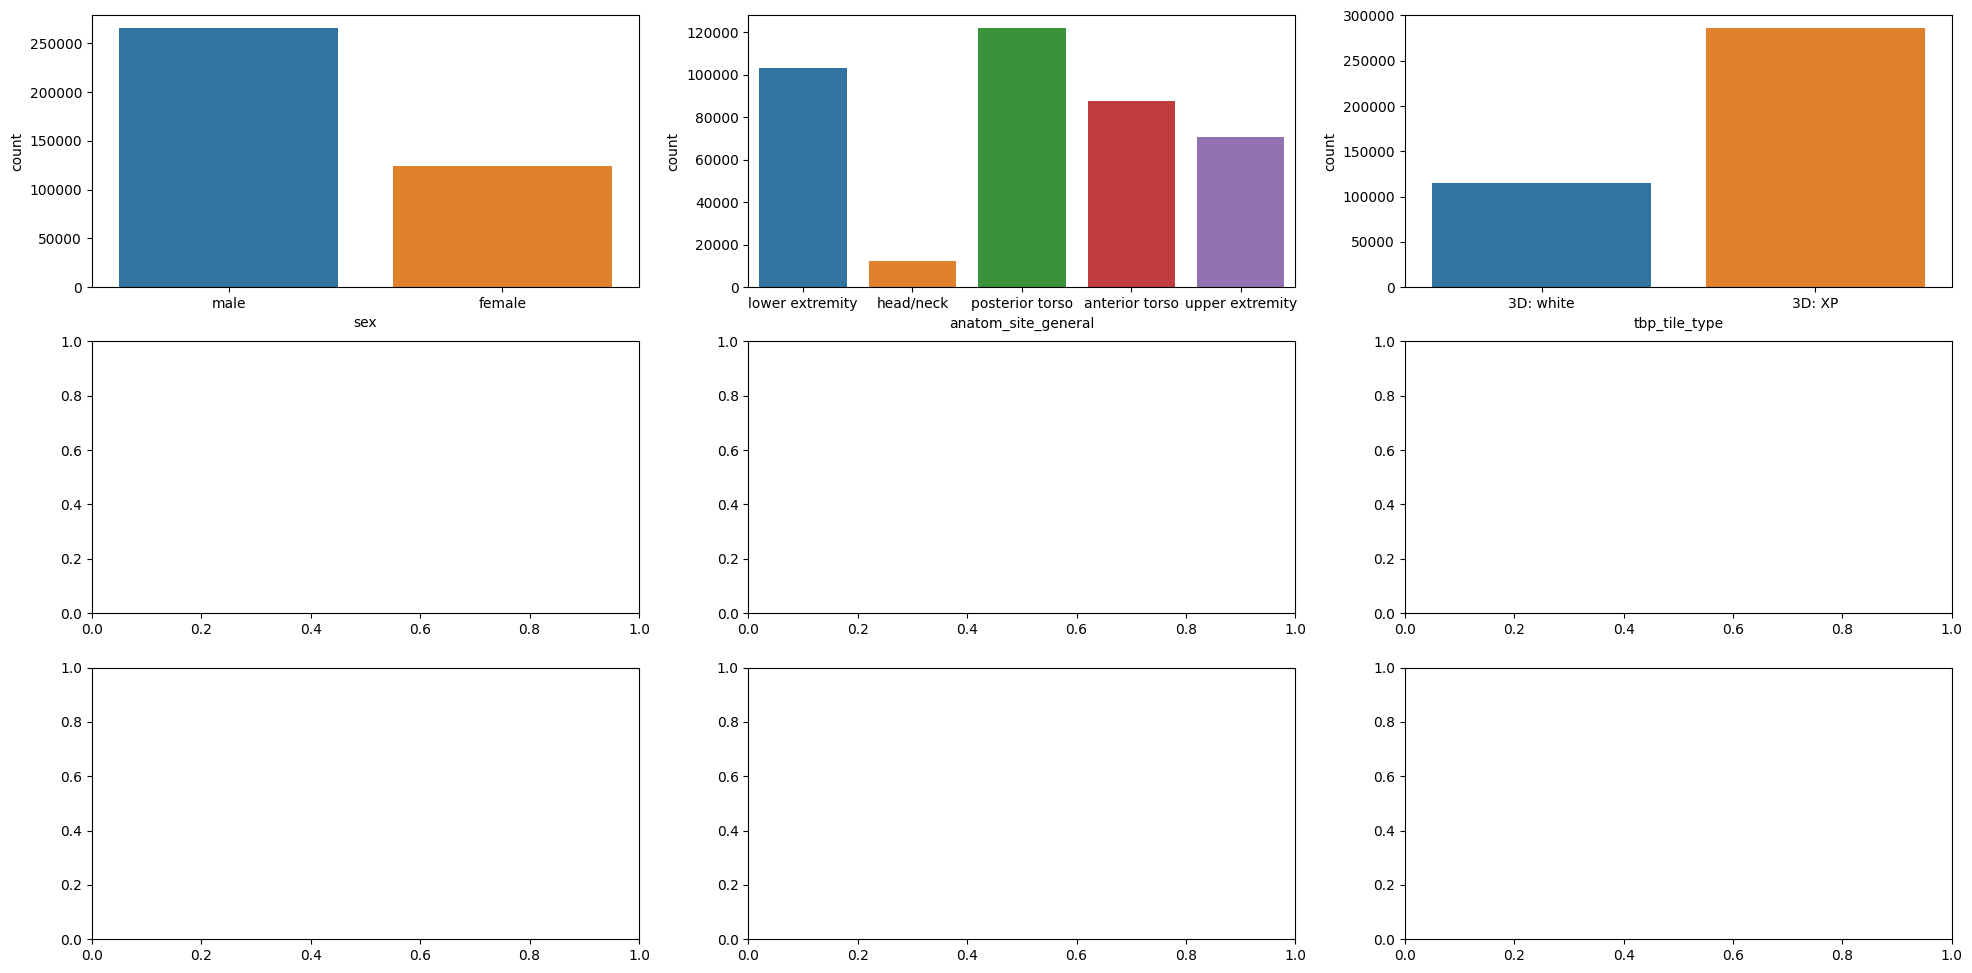

In [7]:
def plot_tabular_data(metadata):
    fig, axes = plt.subplots(3, 3, figsize=(24, 12))
    sns.countplot(data=metadata, x="sex", ax=axes[0][0])
    sns.countplot(data=metadata, x="anatom_site_general", ax=axes[0][1])
    sns.countplot(data=metadata, x="tbp_tile_type", ax=axes[0][2])

plot_tabular_data(metadata=df)

# Balance the data a bit more

In [8]:
total_positive = df[df["target"]==1]["target"].count()
total_negative = df[df["target"]==0]["target"].count()
print(f"data is very unbalanced --> {total_positive} positive to {total_negative} negatives; ratio of {total_positive/total_negative*100}%")

new_ratio = 100 # 2000% more negatives than positives
new_df = pd.concat([df[df["target"] == 1], df.iloc[:total_positive*(int(new_ratio/100)), :]]).reset_index(drop=True)
new_df.head(5)
new_df_ratio = new_df[new_df["target"]==0]["target"].count()/new_df[new_df["target"]==1]["target"].count()
print(new_df[new_df["target"]==0]["target"].count())
print(f"new ratio is now {new_df_ratio*100}% (target 0 / target 1); around {new_ratio}% more 0 than 1")


data is very unbalanced --> 393 positive to 400666 negatives; ratio of 0.09808668566836218%
392
new ratio is now 99.49238578680203% (target 0 / target 1); around 100% more 0 than 1


In [9]:
dataset = ISICDataset(metadata=new_df, hdf_path=hdf_path)

# Plotting samples

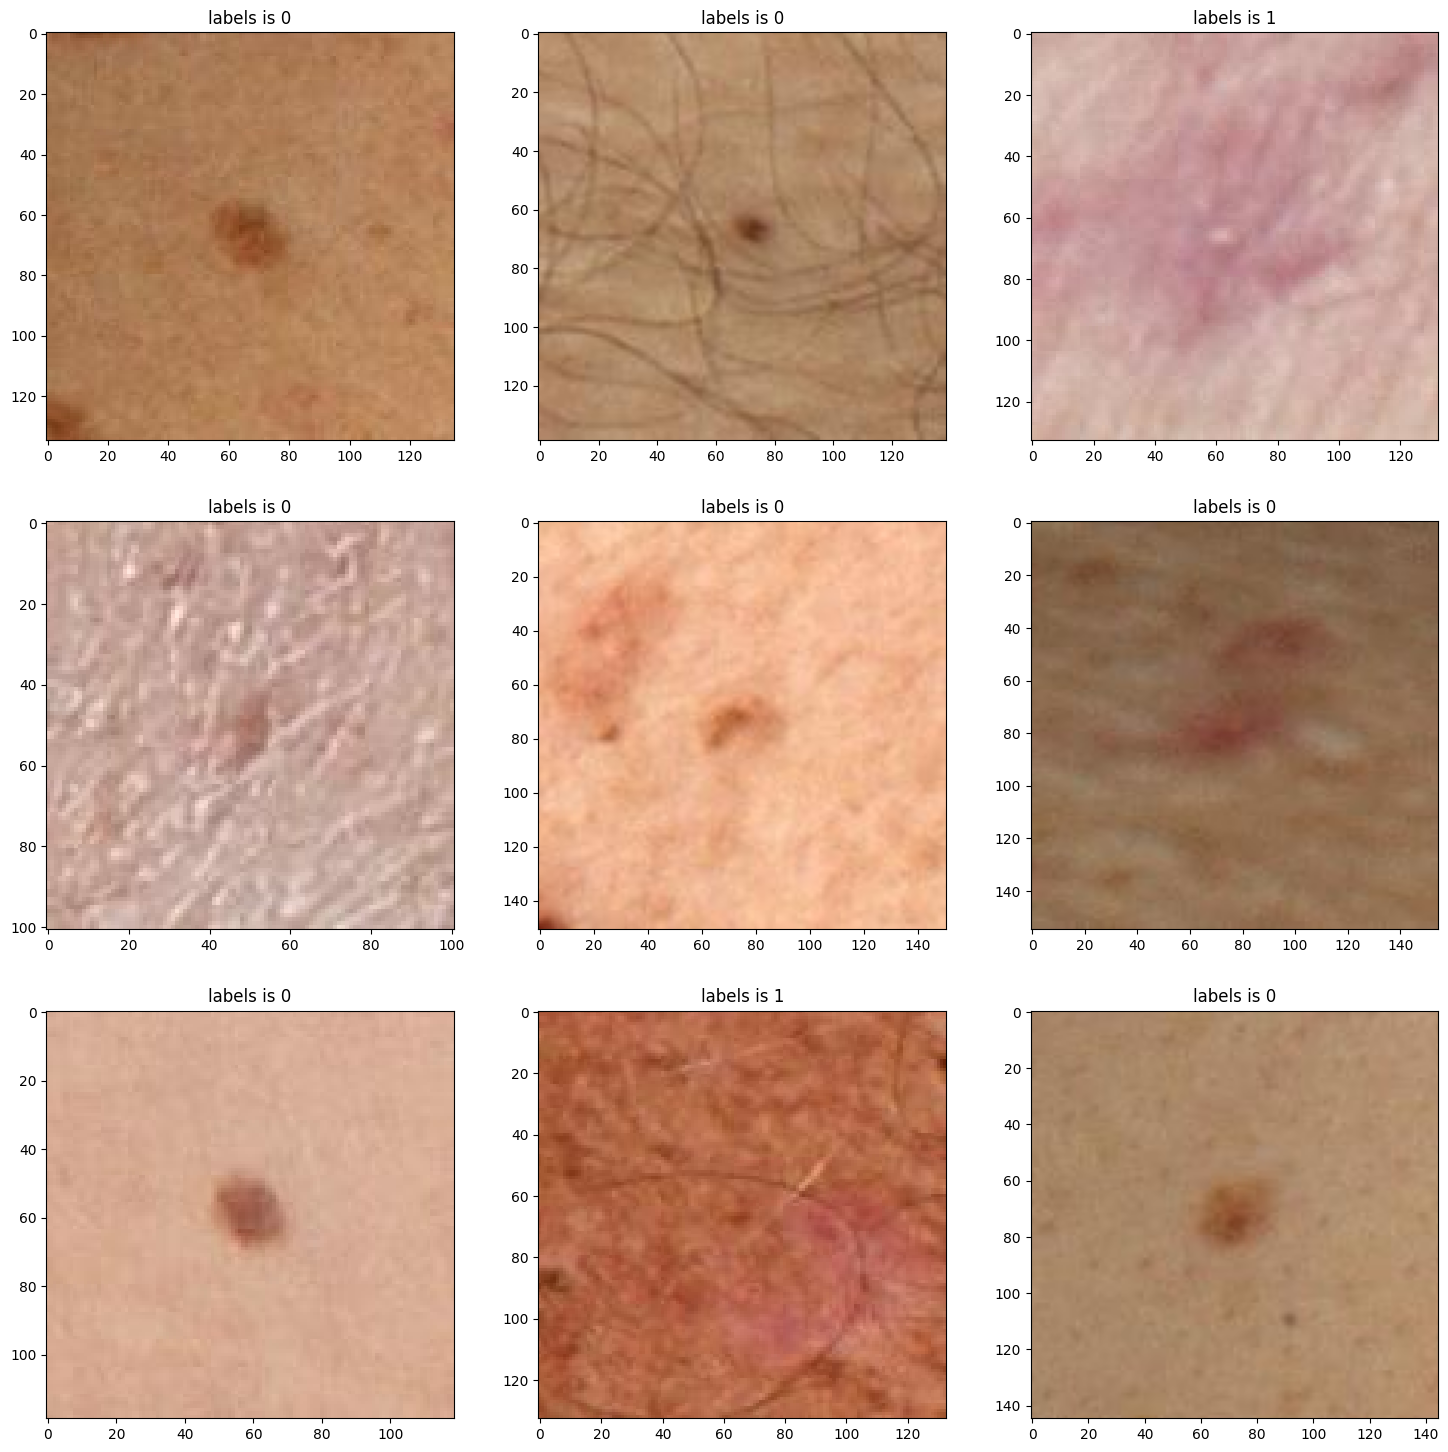

In [10]:
def plot_samples(metadata, dataset, transformed: bool = False):
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    xy = torch.randint(0, metadata["isic_id"].nunique(), (3, 3))
    for x_idx, x in enumerate(xy):
        for y_idx, y in enumerate(x):
            #axes[x_idx][y_idx].plot(dataset[y.cpu().item()].cpu().detach().numpy())
            if transformed:
                axes[x_idx][y_idx].imshow(dataset[y.cpu().item()]["img"].permute(1, 2, 0).cpu().detach().numpy())
                axes[x_idx][y_idx].set_title(f"labels is {metadata.iloc[y.cpu().item()]['target']}")
            else:
                axes[x_idx][y_idx].imshow(dataset[y.cpu().item()]["img"].cpu().detach().numpy())
                axes[x_idx][y_idx].set_title(f"labels is {metadata.iloc[y.cpu().item()]['target']}")




plot_samples(metadata=new_df, dataset=dataset)
    

# Data augmentation

In [11]:
torchvision.transforms.RandomRotation(degrees=90)
torchvision.transforms.Resize(size=224, max_size=224)
torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torchvision.transforms.ToTensor()
torchvision.transforms.RandomSolarize(p=0.2, threshold=150)
torchvision.transforms.RandomVerticalFlip(p=0.2)
torchvision.transforms.RandomHorizontalFlip(p=0.2)

RandomHorizontalFlip(p=0.2)

In [12]:
img_size = 334
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(img_size, img_size)),
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.RandomVerticalFlip(p=0.2),
    #torchvision.transforms.RandomSolarize(p=0.02, threshold=90),
    #torchvision.transforms.ColorJitter(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758])
])

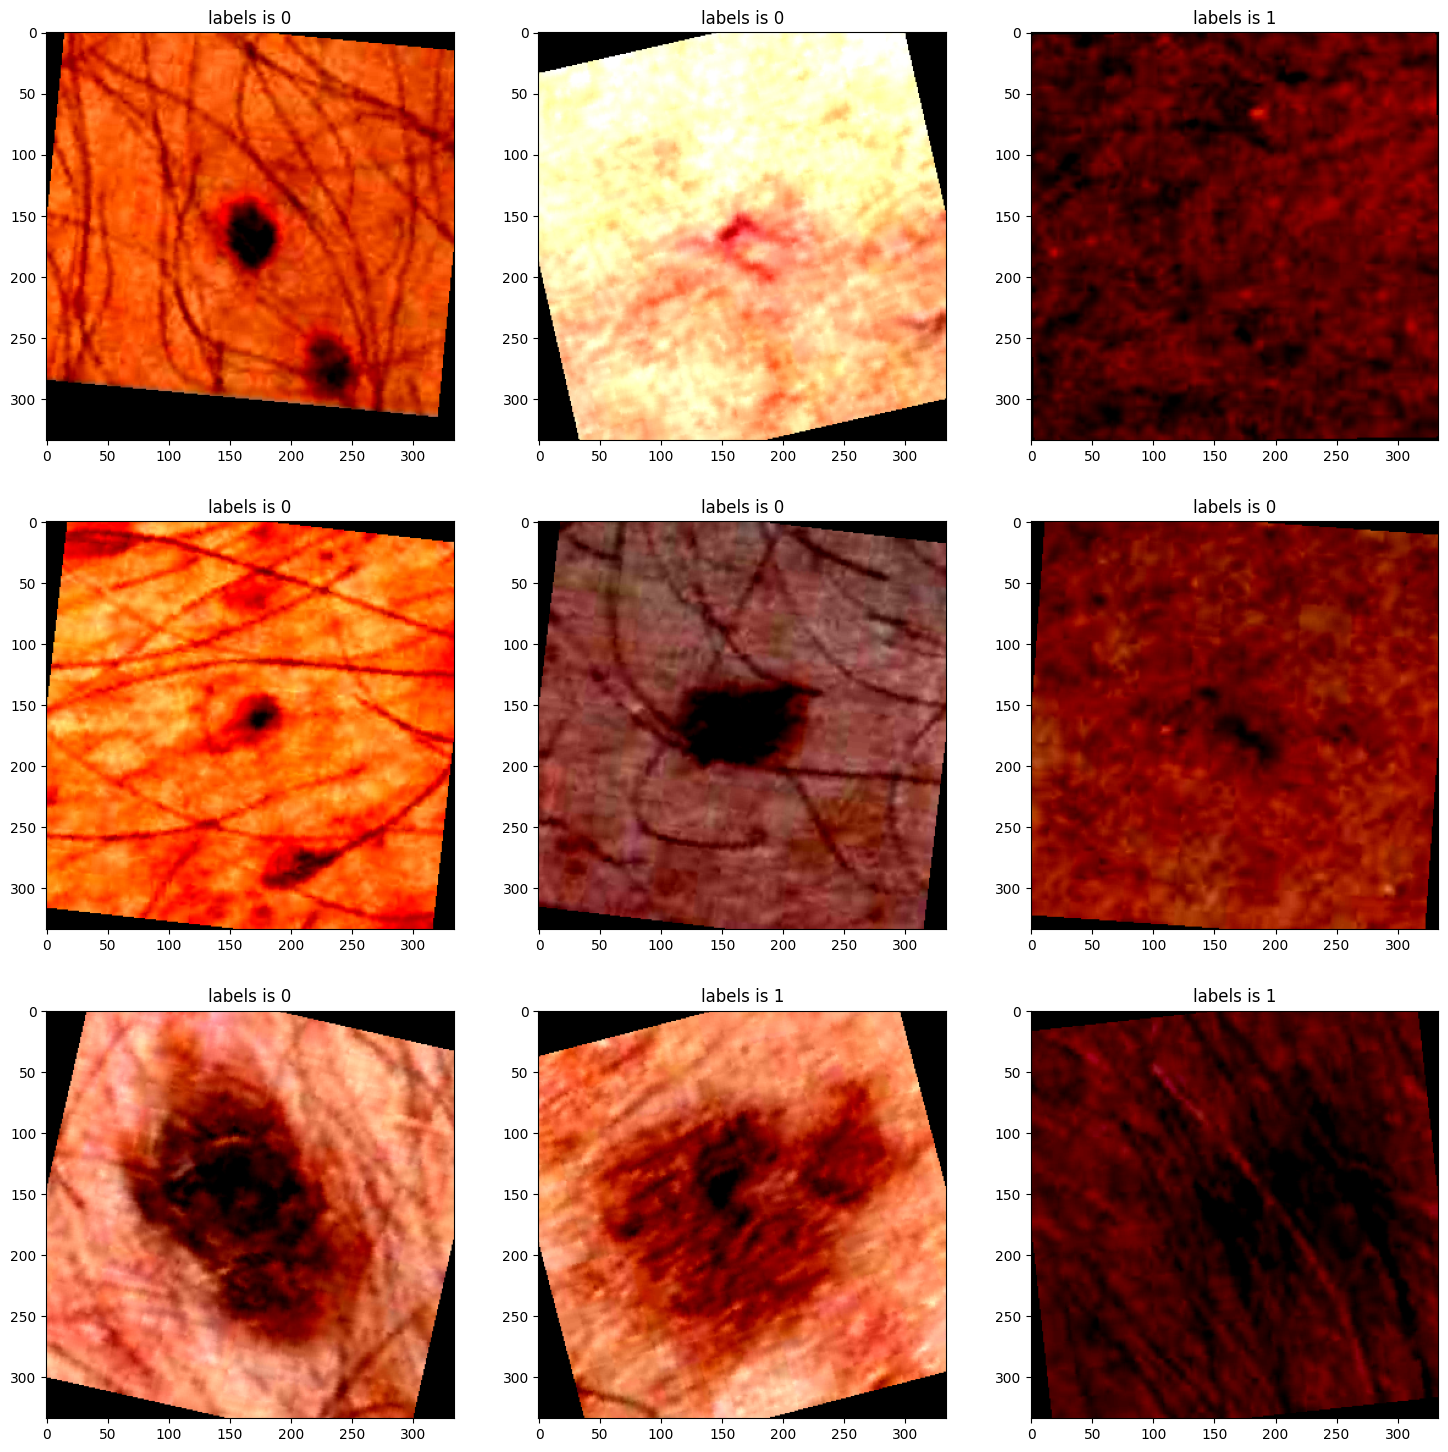

In [13]:
dataset = ISICDataset(metadata=new_df, hdf_path=hdf_path, transforms=transforms)
plot_samples(dataset=dataset, metadata=new_df, transformed=True)

# Models

In [14]:
@dataclass
class ViTConfig:
    n_embd: int = 512
    img_size: Tuple[int, int] = (224, 224)
    patch_size: Tuple[int, int] = (32, 32)
    in_channels: int = 3
    n_layers: int = 4
    n_heads: int = 12
    head_size: int = None
    n_classes: int = 1
    dropout: float = 0.1
    qvk_bias: bool = False

    def __post_init__(self):
        if self.head_size is None:
            self.head_size = self.n_embd//self.n_heads
            
                
            
class AttentionHead(nn.Module):
    def __init__(self, config: ViTConfig):
        super(AttentionHead, self).__init__()

        self.Q = nn.Linear(in_features=config.n_embd, out_features=config.head_size, bias=config.qvk_bias)
        self.K = nn.Linear(in_features=config.n_embd, out_features=config.head_size, bias=config.qvk_bias)
        self.V = nn.Linear(in_features=config.n_embd, out_features=config.head_size, bias=config.qvk_bias)
        self.dropout = nn.Dropout(config.dropout)

        #self.register_buffer("tril", torch.ones(size=(config.context_size, config.context_size)))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        q = self.Q(x) # (B, n_patches + 1, n_embd) @ (B, n_embd, head_size) --> (B, n_patches + 1, head_size)
        v = self.V(x) # (B, n_patches + 1, n_embd) @ (B, n_embd, head_size) --> (B, n_patches + 1, head_size)
        k = self.K(x) # (B, n_patches + 1, n_embd) @ (B, n_embd, head_size) --> (B, n_patches + 1, head_size)

        attention = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5) # (B, n_patches + 1, head_size) @ (B, head_size, n_patches + 1) --> (B, n_patches + 1, n_patches + 1)
        self.dropout(attention)
        #attention = attention.masked_fill(self.tril[:T, :T]==0, float('-inf'))
        attention = torch.softmax(attention, dim=-1)

        x = attention @ v # (B, n_patches + 1, n_patches + 1) @ (B, n_patches + 1, head_size) --> (B, n_patches + 1, head_size)
        return x


class MultiheadAttention(nn.Module):
    def __init__(self, config: ViTConfig):
        super(MultiheadAttention, self).__init__()

        self.sa_heads = nn.ModuleList([AttentionHead(config=config) for _ in range(config.n_heads)])
        self.projection = nn.Linear(in_features=config.n_heads*config.head_size, out_features=config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat([head(x) for head in self.sa_heads], dim=-1)
        x = self.dropout(self.projection(x))
        return x

class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_size, dropout):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_size, out_features=out_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

class EncoderBlock(nn.Module):
    def __init__(self, config: ViTConfig):
        super(EncoderBlock, self).__init__()

        self.multihead_attention = MultiheadAttention(config=config)
        self.mlp = MLP(in_features=config.n_embd, out_features=config.n_embd, hidden_size=config.n_embd*4, dropout=config.dropout)
        self.layernorm1 = nn.LayerNorm(config.n_embd)
        self.layernorm2 = nn.LayerNorm(config.n_embd)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.multihead_attention(self.layernorm1(x))
        x = self.dropout(x)
        x = x + self.mlp(self.layernorm2(x))
        x = self.dropout(x)
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, config: ViTConfig):
        super(PatchEmbedding, self).__init__()
        self.config = config
        self.img_size = config.img_size
        self.patch_size = config.patch_size

        self.n_patches = (self.img_size[0]//self.patch_size[0]) * (self.img_size[1]//self.patch_size[1])

        self.projection = nn.Conv2d(in_channels=config.in_channels, out_channels=config.n_embd, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x of shape B, C, W, H
        B, C, W, H = x.shape
        x = self.projection(x) # B, C, W, H --> B, n_embd, sqrt(n_patches), sqrt(n_patches); because sqrt(n_patches)*sqrt(n_patches) == n_patches
        #print(f"x o shape {x.shape}; n_patches is {self.n_patches}; n_embd is {self.config.n_embd}")
        x = x.view(B, -1, self.config.n_embd) # B, n_patches, n_embd
        return x

class ViT(nn.Module):
    def __init__(self, config: ViTConfig):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(config=config)
        self.cls_token = nn.Parameter(torch.zeros(size=(1, 1, config.n_embd)))
        self.pos = nn.Parameter(torch.zeros(size=(1, self.patch_embedding.n_patches+1, config.n_embd))) # learnable param rather than a fixed range
        self.dropout = nn.Dropout(config.dropout)

        #self.attention_head = AttentionHead(config)
        #self.multihead_attention = MultiheadAttention(config)
        self.blocks = nn.ModuleList([EncoderBlock(config=config) for _ in range(config.n_layers)])
        self.dropout = nn.Dropout(config.dropout)


        self.layernorm = nn.LayerNorm(config.n_embd)
        self.classifier = nn.Linear(in_features=config.n_embd, out_features=config.n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, W, H = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = self.patch_embedding(x) # (B, n_patches, n_embd)
        x = torch.cat([cls_token, x], dim=1) # cls_token at x[:, 0, :]
        x = x + self.pos # (B, n_patches+1, n_embd) + (1, n_patches+1, n_embd)
        x = self.dropout(x)

        #x = self.attention_head(x)
        #x = self.multihead_attention(x)
        for block in self.blocks:
            x = block(x)
        
        x = self.dropout(x)

        x = self.layernorm(x)

        cls_token_representation = x[:, 0, :] # B, n_embd
        x = self.classifier(cls_token_representation) # (B, n_embd) @ (n_embd, n_classes) --> (B, n_classes)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(ResnetBlock, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, kernel_size=(3, 3), stride=stride, padding=padding, out_channels=out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, kernel_size=(3, 3), padding=1, out_channels=out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), stride=stride, padding=padding)

        self.act_fn = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv_block1(x)
        out = self.act_fn(out)

        if self.downsample is not None:
            identity = self.downsample(identity) # keep the same dimensionality for element-wise addition
        #print(identity.shape)
        out = self.conv_block2(out) + identity
        out = self.act_fn(out)
        return out


    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.resnet_layer1 = self.make_layer(in_channels=3, out_channels=16, stride=2, padding=1, n_blocks=2) 
        self.resnet_layer2 = self.make_layer(in_channels=16, out_channels=32, stride=2, padding=1, n_blocks=2) 
        self.resnet_layer3 = self.make_layer(in_channels=32, out_channels=64, stride=2, padding=1, n_blocks=2) 
        self.resnet_layer4 = self.make_layer(in_channels=64, out_channels=128, stride=2, padding=1, n_blocks=2) 

        self.classifier = nn.Linear(in_features=25088, out_features=1)

    
    def make_layer(self, in_channels, out_channels, stride, padding, n_blocks):
        layers = []
        layers.append(ResnetBlock(in_channels=in_channels, out_channels=out_channels, stride=stride, padding=padding))

        for _ in range(1, n_blocks):
            layers.append(ResnetBlock(in_channels=out_channels, out_channels=out_channels, stride=1, padding=1))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        x = self.resnet_layer1(x)
        x = self.resnet_layer2(x)
        x = self.resnet_layer3(x)
        x = self.resnet_layer4(x)

        x = x.view(B, -1)
        return self.classifier(x)



 

# Model trainer classs
- with stratified group k fold

In [15]:
group_fold = StratifiedGroupKFold(n_splits=5, shuffle=True)
class ModelTrainer:
    def __init__(self, model, train_dataset, val_dataset, criterion, optimizer, scheduler, batch_size):

        self.model = model

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.batch_size = batch_size

        self.last_acc = 0

    def fit(self, dataloader):
        self.model.train()
        accumulated_loss = 0
        for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            logits = self.model(batch["img"].to(device)) # transforms.COompose makes the device cpu instead of cuda
            loss = self.criterion(logits.flatten(), batch["label"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accumulated_loss += loss/len(dataloader)
            if (batch_idx+1) % 100 == 0:
                print(f"loss for batch {batch_idx + 1} --> {accumulated_loss}")
                accumulated_loss = 0

    def val(self, dataloader):
        self.model.eval()
        accumulated_loss = 0
        total_correct = 0
        total_inputs = 0
        with torch.inference_mode():
            for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
                logits = self.model(batch["img"].to(device))
                loss = self.criterion(logits.flatten(), batch["label"])
                accumulated_loss += loss / len(dataloader)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                
                total_inputs += self.batch_size
                total_correct += (preds.flatten()==batch["label"]).sum().item()
        print(f"acc of {total_correct/total_inputs*100}; {total_correct} out of {total_inputs}; current lr --> {scheduler.get_last_lr()}")
        self.last_acc = total_correct/total_inputs

            

    def make_dataloaders(self, train_idx, val_idx):
        train_subset = Subset(dataset=self.train_dataset, indices=train_idx)
        val_subset = Subset(dataset=self.val_dataset, indices=val_idx)

        train_dataloader = DataLoader(dataset=train_subset, batch_size=self.batch_size, generator=torch.Generator(device=device), shuffle=True)
        val_dataloader = DataLoader(dataset=val_subset, batch_size=self.batch_size, generator=torch.Generator(device=device), shuffle=True)

        return (train_dataloader, val_dataloader)

    def train_model(self, n_folds, epochs, epochs_per_fold):
        group_fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True)
        for epoch in range(epochs):
            for fold, (train_idx, val_idx) in enumerate(group_fold.split(X=new_df, y=new_df["target"], groups=new_df["patient_id"])):
                train_dataloader, val_dataloader = self.make_dataloaders(train_idx=train_idx, val_idx=val_idx)

                for fold_epoch in range(epochs_per_fold):
                    self.fit(dataloader=train_dataloader)
                    self.val(dataloader=val_dataloader)
                    self.scheduler.step()

                


batch_size = 128
train_dataset = ISICDataset(hdf_path="/home/nekurumi/Downloads/backup/coding/Skin-Cancer-Detection-/train-image.hdf5", metadata=new_df, transforms=torchvision.transforms.Compose([torchvision.transforms.Resize(size=img_size), torchvision.transforms.ToTensor()]))
#train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Resize(size=img_size), torchvision.transforms.ToTensor()]))
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, generator=torch.Generator(device=device), shuffle=False)

mean = torch.zeros(size=(3,))
std = torch.zeros(size=(3,))
total = 0

for batch in tqdm(train_dataloader):
    img = batch["img"].to(device)
    img = img.view(img.size(0), img.size(1), -1)
    mean += img.mean(dim=2).sum(dim=0)
    std += img.std(dim=2).sum(dim=0)
    total += img.size(0)

#for img, _ in tqdm(train_dataloader):
    #img = img.to(device)
    #img = img.view(img.size(0), img.size(1), -1)
    #mean += img.mean(dim=2).sum(dim=0)
    #std += img.std(dim=2).sum(dim=0)
    #total += img.size(0)

mean = mean/total
std = std/total
print(mean, std)

# Simple model for submission test

In [16]:
vit_config = ViTConfig()
vit_config.img_size = (img_size, img_size)
model = ViT(config=vit_config)
#model = CNN()

model.to(device)
#optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((100/new_ratio), dtype=torch.float32))
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(img_size, img_size)),
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.RandomVerticalFlip(p=0.2),
    #torchvision.transforms.RandomSolarize(p=0.02, threshold=90),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758])
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758])
])
train_dataset = ISICDataset(hdf_path="/kaggle/input/isic-2024-challenge/train-image.hdf5", metadata=new_df, transforms=train_transforms)
val_dataset = ISICDataset(hdf_path="/kaggle/input/isic-2024-challenge/train-image.hdf5", metadata=new_df, transforms=val_transforms)


In [17]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
batch_size = 8
epochs = 6
epochs_per_fold = 2
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer, 
    num_warmup_steps=epochs*batch_size*0.1,
    num_training_steps=epochs*batch_size
    )

model_trainer = ModelTrainer(model=model, train_dataset=train_dataset, val_dataset=val_dataset, batch_size=batch_size, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

In [18]:
model_trainer.train_model(n_folds=5, epochs=epochs, epochs_per_fold=epochs_per_fold)

100%|██████████| 20/20 [00:01<00:00, 13.79it/s]


acc of 42.5; 68 out of 160; current lr --> [0.0]


100%|██████████| 20/20 [00:01<00:00, 19.63it/s]


acc of 57.49999999999999; 92 out of 160; current lr --> [2.0833333333333334e-06]


100%|██████████| 21/21 [00:01<00:00, 19.04it/s]


acc of 61.30952380952381; 103 out of 168; current lr --> [4.166666666666667e-06]


100%|██████████| 21/21 [00:01<00:00, 19.53it/s]


acc of 66.07142857142857; 111 out of 168; current lr --> [6.2499999999999995e-06]


100%|██████████| 18/18 [00:00<00:00, 19.57it/s]


acc of 65.97222222222221; 95 out of 144; current lr --> [8.333333333333334e-06]


100%|██████████| 18/18 [00:00<00:00, 20.28it/s]


acc of 70.13888888888889; 101 out of 144; current lr --> [9.999471159635538e-06]


100%|██████████| 21/21 [00:01<00:00, 19.39it/s]


acc of 71.42857142857143; 120 out of 168; current lr --> [9.980973490458728e-06]


100%|██████████| 21/21 [00:01<00:00, 20.19it/s]


acc of 73.80952380952381; 124 out of 168; current lr --> [9.936145565586871e-06]


100%|██████████| 20/20 [00:00<00:00, 20.16it/s]


acc of 72.5; 116 out of 160; current lr --> [9.86522435289912e-06]


100%|██████████| 20/20 [00:00<00:00, 20.42it/s]


acc of 75.625; 121 out of 160; current lr --> [9.768584753741134e-06]


100%|██████████| 22/22 [00:01<00:00, 19.98it/s]


acc of 76.13636363636364; 134 out of 176; current lr --> [9.646737621134112e-06]


100%|██████████| 22/22 [00:01<00:00, 19.56it/s]


acc of 75.0; 132 out of 176; current lr --> [9.500327059320606e-06]


100%|██████████| 20/20 [00:00<00:00, 20.34it/s]


acc of 71.875; 115 out of 160; current lr --> [9.330127018922195e-06]


100%|██████████| 20/20 [00:00<00:00, 20.61it/s]


acc of 72.5; 116 out of 160; current lr --> [9.137037205707552e-06]


100%|██████████| 19/19 [00:00<00:00, 20.87it/s]


acc of 71.05263157894737; 108 out of 152; current lr --> [8.922078324597881e-06]


100%|██████████| 19/19 [00:00<00:00, 21.04it/s]


acc of 67.10526315789474; 102 out of 152; current lr --> [8.68638668405062e-06]


100%|██████████| 23/23 [00:01<00:00, 20.72it/s]


acc of 79.8913043478261; 147 out of 184; current lr --> [8.43120818934367e-06]


100%|██████████| 23/23 [00:01<00:00, 20.02it/s]


acc of 79.34782608695652; 146 out of 184; current lr --> [8.157891756512488e-06]


100%|██████████| 16/16 [00:00<00:00, 20.24it/s]


acc of 82.8125; 106 out of 128; current lr --> [7.86788218175523e-06]


100%|██████████| 16/16 [00:00<00:00, 20.65it/s]


acc of 83.59375; 107 out of 128; current lr --> [7.5627125039993275e-06]


100%|██████████| 21/21 [00:01<00:00, 19.78it/s]


acc of 80.35714285714286; 135 out of 168; current lr --> [7.243995901002312e-06]


100%|██████████| 21/21 [00:01<00:00, 20.51it/s]


acc of 82.73809523809523; 139 out of 168; current lr --> [6.913417161825451e-06]


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]


acc of 77.97619047619048; 131 out of 168; current lr --> [6.57272378075807e-06]


100%|██████████| 21/21 [00:01<00:00, 20.49it/s]


acc of 77.97619047619048; 131 out of 168; current lr --> [6.2237167197716195e-06]


100%|██████████| 18/18 [00:00<00:00, 19.18it/s]


acc of 80.55555555555556; 116 out of 144; current lr --> [5.8682408883346535e-06]


100%|██████████| 18/18 [00:00<00:00, 18.55it/s]


acc of 82.63888888888889; 119 out of 144; current lr --> [5.508175390914011e-06]


100%|██████████| 17/17 [00:00<00:00, 20.34it/s]


acc of 79.41176470588235; 108 out of 136; current lr --> [5.1454235937155584e-06]


100%|██████████| 17/17 [00:00<00:00, 20.47it/s]


acc of 79.41176470588235; 108 out of 136; current lr --> [4.781903063173321e-06]


100%|██████████| 23/23 [00:01<00:00, 21.01it/s]


acc of 80.43478260869566; 148 out of 184; current lr --> [4.419535429373851e-06]


100%|██████████| 23/23 [00:01<00:00, 20.78it/s]


acc of 81.52173913043478; 150 out of 184; current lr --> [4.060236227999442e-06]


100%|██████████| 21/21 [00:01<00:00, 19.98it/s]


acc of 79.76190476190477; 134 out of 168; current lr --> [3.705904774487398e-06]


100%|██████████| 21/21 [00:01<00:00, 19.80it/s]


acc of 82.14285714285714; 138 out of 168; current lr --> [3.3584141239321966e-06]


100%|██████████| 23/23 [00:01<00:00, 19.74it/s]


acc of 75.0; 138 out of 184; current lr --> [3.019601169804218e-06]


100%|██████████| 23/23 [00:01<00:00, 19.71it/s]


acc of 73.91304347826086; 136 out of 184; current lr --> [2.6912569338248317e-06]


100%|██████████| 19/19 [00:00<00:00, 19.55it/s]


acc of 80.26315789473685; 122 out of 152; current lr --> [2.3751170983272015e-06]


100%|██████████| 19/19 [00:00<00:00, 20.33it/s]


acc of 80.92105263157895; 123 out of 152; current lr --> [2.0728528311503e-06]


100%|██████████| 19/19 [00:00<00:00, 20.42it/s]


acc of 76.31578947368422; 116 out of 152; current lr --> [1.7860619515673034e-06]


100%|██████████| 19/19 [00:00<00:00, 20.63it/s]


acc of 75.6578947368421; 115 out of 152; current lr --> [1.5162604839467265e-06]


100%|██████████| 19/19 [00:00<00:00, 20.08it/s]


acc of 82.89473684210526; 126 out of 152; current lr --> [1.264874643795021e-06]


100%|██████████| 19/19 [00:00<00:00, 19.99it/s]


acc of 82.23684210526315; 125 out of 152; current lr --> [1.0332332985438248e-06]


100%|██████████| 19/19 [00:00<00:00, 19.54it/s]


acc of 80.92105263157895; 123 out of 152; current lr --> [8.22560942935317e-07]


100%|██████████| 19/19 [00:00<00:00, 20.20it/s]


acc of 80.92105263157895; 123 out of 152; current lr --> [6.339712261390213e-07]


100%|██████████| 20/20 [00:00<00:00, 20.12it/s]


acc of 80.0; 128 out of 160; current lr --> [4.6846106481675035e-07]


100%|██████████| 20/20 [00:00<00:00, 20.21it/s]


acc of 80.0; 128 out of 160; current lr --> [3.269053732550581e-07]


100%|██████████| 19/19 [00:00<00:00, 20.25it/s]


acc of 81.57894736842105; 124 out of 152; current lr --> [2.1005243842255552e-07]


100%|██████████| 19/19 [00:00<00:00, 20.36it/s]


acc of 81.57894736842105; 124 out of 152; current lr --> [1.185199644003332e-07]


100%|██████████| 21/21 [00:01<00:00, 20.77it/s]


acc of 79.16666666666666; 133 out of 168; current lr --> [5.279180709527765e-08]


100%|██████████| 21/21 [00:01<00:00, 20.78it/s]


acc of 79.16666666666666; 133 out of 168; current lr --> [1.3215416497138756e-08]


100%|██████████| 21/21 [00:01<00:00, 20.36it/s]


acc of 83.33333333333334; 140 out of 168; current lr --> [0.0]


100%|██████████| 21/21 [00:01<00:00, 19.67it/s]


acc of 83.33333333333334; 140 out of 168; current lr --> [1.3215416497138756e-08]


100%|██████████| 24/24 [00:01<00:00, 19.93it/s]


acc of 78.64583333333334; 151 out of 192; current lr --> [5.279180709527765e-08]


100%|██████████| 24/24 [00:01<00:00, 20.45it/s]


acc of 78.64583333333334; 151 out of 192; current lr --> [1.1851996440033265e-07]


100%|██████████| 18/18 [00:00<00:00, 20.49it/s]


acc of 77.77777777777779; 112 out of 144; current lr --> [2.1005243842255497e-07]


100%|██████████| 18/18 [00:00<00:00, 20.12it/s]


acc of 77.77777777777779; 112 out of 144; current lr --> [3.2690537325505756e-07]


100%|██████████| 18/18 [00:00<00:00, 20.60it/s]


acc of 81.94444444444444; 118 out of 144; current lr --> [4.684610648167498e-07]


100%|██████████| 18/18 [00:00<00:00, 20.75it/s]


acc of 81.94444444444444; 118 out of 144; current lr --> [6.339712261390208e-07]


100%|██████████| 19/19 [00:00<00:00, 20.59it/s]


acc of 80.92105263157895; 123 out of 152; current lr --> [8.225609429353165e-07]


100%|██████████| 19/19 [00:00<00:00, 20.31it/s]


acc of 82.89473684210526; 126 out of 152; current lr --> [1.033233298543823e-06]


100%|██████████| 22/22 [00:01<00:00, 20.86it/s]


acc of 78.97727272727273; 139 out of 176; current lr --> [1.2648746437950187e-06]


100%|██████████| 22/22 [00:01<00:00, 20.31it/s]

acc of 79.54545454545455; 140 out of 176; current lr --> [1.5162604839467238e-06]


# Test submission

In [19]:
test_df = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
test_df.head(2)

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


In [20]:
test_dataset = ISICDataset(hdf_path="/kaggle/input/isic-2024-challenge/test-image.hdf5", metadata=test_df, transforms=val_transforms, test_mode=True)

In [21]:
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, generator=torch.Generator(device=device), shuffle=False)
next(iter(test_dataloader))

{'isic_id': ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740'],
 'img': tensor([[[[ 3.1755e-03, -1.1425e-02, -4.0625e-02,  ...,  2.0758e-01,
             1.9298e-01,  1.9298e-01],
           [ 3.1755e-03, -1.1425e-02, -4.0625e-02,  ...,  1.9298e-01,
             1.7838e-01,  1.7838e-01],
           [ 1.7776e-02,  3.1755e-03, -2.6025e-02,  ...,  1.6378e-01,
             1.6378e-01,  1.6378e-01],
           ...,
           [-1.2822e-01, -1.2822e-01, -1.4282e-01,  ..., -1.8662e-01,
            -2.0122e-01, -1.8662e-01],
           [-1.1362e-01, -1.1362e-01, -1.1362e-01,  ..., -2.0122e-01,
            -1.8662e-01, -1.7202e-01],
           [-1.1362e-01, -1.1362e-01, -9.9025e-02,  ..., -2.0122e-01,
            -1.8662e-01, -1.7202e-01]],
 
          [[-6.5643e-01, -6.7144e-01, -7.0145e-01,  ..., -4.7634e-01,
            -4.9134e-01, -4.9134e-01],
           [-6.5643e-01, -6.7144e-01, -7.0145e-01,  ..., -4.9134e-01,
            -5.0635e-01, -5.0635e-01],
           [-6.4142e-01, -6.5643e-01, -6

# Get predictions out of the model

In [22]:
# Predicting just from the model
def predict(model, dataloader):
    model.eval()
    output_df = {
        "isic_id": [],
        "target": []
    }
    with torch.inference_mode():
        for batch in tqdm_notebook(dataloader):
            print(batch["isic_id"])
            logits = model(batch["img"].to(device))
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            preds = preds.flatten().tolist()
            for isic_id, pred in zip(batch["isic_id"], preds):
                output_df["isic_id"].append(isic_id)
                output_df["target"].append(pred)

    return pd.DataFrame(output_df)

#submission_df = predict(model=model, dataloader=test_dataloader)
#submission_df.to_csv("./submission.csv", index=False)

In [23]:
xgb_classifier = xgb.XGBClassifier(tree_method="gpu_hist")
xgb_df = new_df.drop(columns=["isic_id", "patient_id"])
xgb_df.drop(columns=["lesion_id", "copyright_license"], inplace=True)

# get the common columns between test and train
common_columns = xgb_df.columns.intersection(test_df.columns)
uncommon_columns = xgb_df.drop(columns=common_columns).columns
print(uncommon_columns)
uncommon_columns = xgb_df.drop(columns=common_columns).columns[1:] # keep target for training
print(uncommon_columns)
xgb_df.drop(columns=uncommon_columns, inplace=True)

# map sex and deal with nan values
xgb_df["sex"] = xgb_df["sex"].fillna(0)
sex_map = {"female": 1, "male": 0, 0: 0}
xgb_df["sex"] = xgb_df["sex"].map(sex_map)

xgb_df.drop(columns=["image_type"], inplace=True) # there is just a single image type

print(xgb_df["tbp_tile_type"].unique())
tile_type_map = {k: v for v, k in enumerate(xgb_df["tbp_tile_type"].unique())}
xgb_df["tbp_tile_type"] = xgb_df["tbp_tile_type"].map(tile_type_map)
print(xgb_df["tbp_tile_type"].unique())


xgb_df["anatom_site_general"] = xgb_df["anatom_site_general"].fillna("posterior torso") # most of them are posterior torso
anatom_map = {k: v for v, k in enumerate(xgb_df["anatom_site_general"].unique())}
print(anatom_map)
xgb_df["anatom_site_general"] = xgb_df["anatom_site_general"].map(anatom_map)

attribution_map = {k: v for v, k in enumerate(xgb_df["attribution"].unique())}
print(attribution_map)
xgb_df["attribution"] = xgb_df["attribution"].map(attribution_map)
print(xgb_df["attribution"].unique())

location_map = {k: v for v, k in enumerate(xgb_df["tbp_lv_location"].unique())}
print(location_map)
xgb_df["tbp_lv_location"] = xgb_df["tbp_lv_location"].map(location_map)

location_simple_map = {k: v for v, k in enumerate(xgb_df["tbp_lv_location_simple"].unique())}
print(location_simple_map)
xgb_df["tbp_lv_location_simple"] = xgb_df["tbp_lv_location_simple"].map(location_simple_map)


train_tabular, eval_tabular = train_test_split(xgb_df, test_size=0.2, shuffle=True)

Index(['target', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')
Index(['iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')
['3D: XP' '3D: white']
[0 1]
{'anterior torso': 0, 'head/neck': 1, 'upper extremity': 2, 'posterior torso': 3, 'lower extremity': 4}
{'Department of Dermatology, Hospital Clínic de Barcelona': 0, 'Memorial Sloan Kettering Cancer Center': 1, 'Frazer Institute, The University of Queensland, Dermatology Research Centre': 2, 'ACEMID MIA': 3, 'University Hospital of Basel': 4, 'ViDIR Group, Department of Dermatology, Medical University of Vienna': 5, 'Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris': 6}
[0 1 2 3 4 5 6]
{'Torso Front Top Half': 0, 'Hea

In [24]:
def xgb_format(metadata, test_df, test: bool = False):
    #xgb_classifier = xgb.XGBClassifier(tree_method="gpu_hist")
    xgb_df = metadata.drop(columns=["isic_id", "patient_id"])
    if test:
        xgb_df.drop(columns=["copyright_license"], inplace=True)
    else:
        xgb_df.drop(columns=["lesion_id", "copyright_license"], inplace=True)

    # get the common columns between test and train
    common_columns = xgb_df.columns.intersection(test_df.columns)
    uncommon_columns = xgb_df.drop(columns=common_columns).columns
    print(uncommon_columns)
    uncommon_columns = xgb_df.drop(columns=common_columns).columns[1:] # keep target for training
    print(uncommon_columns)
    xgb_df.drop(columns=uncommon_columns, inplace=True)

    # map sex and deal with nan values
    xgb_df["sex"] = xgb_df["sex"].fillna(0)
    sex_map = {"female": 1, "male": 0, 0: 0}
    xgb_df["sex"] = xgb_df["sex"].map(sex_map)

    xgb_df.drop(columns=["image_type"], inplace=True) # there is just a single image type

    print(xgb_df["tbp_tile_type"].unique())
    tile_type_map = {k: v for v, k in enumerate(xgb_df["tbp_tile_type"].unique())}
    xgb_df["tbp_tile_type"] = xgb_df["tbp_tile_type"].map(tile_type_map)
    print(xgb_df["tbp_tile_type"].unique())


    xgb_df["anatom_site_general"] = xgb_df["anatom_site_general"].fillna("posterior torso") # most of them are posterior torso
    anatom_map = {k: v for v, k in enumerate(xgb_df["anatom_site_general"].unique())}
    print(anatom_map)
    xgb_df["anatom_site_general"] = xgb_df["anatom_site_general"].map(anatom_map)

    attribution_map = {k: v for v, k in enumerate(xgb_df["attribution"].unique())}
    print(attribution_map)
    xgb_df["attribution"] = xgb_df["attribution"].map(attribution_map)
    print(xgb_df["attribution"].unique())

    location_map = {k: v for v, k in enumerate(xgb_df["tbp_lv_location"].unique())}
    print(location_map)
    xgb_df["tbp_lv_location"] = xgb_df["tbp_lv_location"].map(location_map)

    location_simple_map = {k: v for v, k in enumerate(xgb_df["tbp_lv_location_simple"].unique())}
    print(location_simple_map)
    xgb_df["tbp_lv_location_simple"] = xgb_df["tbp_lv_location_simple"].map(location_simple_map)

    return xgb_df


In [25]:
for k, v in xgb_df.sample(1).items():
    print(k, v)

target 311    1
Name: target, dtype: int64
age_approx 311    60.0
Name: age_approx, dtype: float64
sex 311    0
Name: sex, dtype: int64
anatom_site_general 311    0
Name: anatom_site_general, dtype: int64
clin_size_long_diam_mm 311    5.1
Name: clin_size_long_diam_mm, dtype: float64
tbp_tile_type 311    0
Name: tbp_tile_type, dtype: int64
tbp_lv_A 311    26.330699
Name: tbp_lv_A, dtype: float64
tbp_lv_Aext 311    13.331042
Name: tbp_lv_Aext, dtype: float64
tbp_lv_B 311    34.430079
Name: tbp_lv_B, dtype: float64
tbp_lv_Bext 311    34.097949
Name: tbp_lv_Bext, dtype: float64
tbp_lv_C 311    43.344388
Name: tbp_lv_C, dtype: float64
tbp_lv_Cext 311    36.611294
Name: tbp_lv_Cext, dtype: float64
tbp_lv_H 311    52.592738
Name: tbp_lv_H, dtype: float64
tbp_lv_Hext 311    68.646332
Name: tbp_lv_Hext, dtype: float64
tbp_lv_L 311    53.823394
Name: tbp_lv_L, dtype: float64
tbp_lv_Lext 311    67.633269
Name: tbp_lv_Lext, dtype: float64
tbp_lv_areaMM2 311    13.867517
Name: tbp_lv_areaMM2, dtype

In [26]:
xgb_df.head(1)

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution
0,1,80.0,1,0,9.27,0,18.093368,13.054772,19.090458,21.211776,...,32.598015,3.514434,5.464301,2.717044,0.472358,0,61.956005,1180.00354,-77.904053,0


In [27]:
def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["area_to_perimeter_ratio"] = df["tbp_lv_areaMM2"] / df["tbp_lv_perimeterMM"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    #df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["symmetry_border_consistency2"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"] / (df["tbp_lv_symm_2axis"] + df["tbp_lv_norm_border"])
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    df["color_consistency2"] = df["tbp_lv_stdL"] * df["tbp_lv_Lext"] / (df["tbp_lv_stdL"] + df["tbp_lv_Lext"])
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    df["age_size_symmetry_index2"] = df["age_approx"] * df["tbp_lv_areaMM2"] * df["tbp_lv_symm_2axis"]
    
    return df


In [28]:
xgb_df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
targets = xgb_df["target"]
test_df = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
df = feature_engineering(xgb_df)
test_df = feature_engineering(test_df)

df = xgb_format(df, test_df, test=False)

df.fillna(df.mean(), inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

train_tabular, eval_tabular = train_test_split(df, test_size=0.1, shuffle=True)
#print(train_tabular.head(1).columns)
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X=train_tabular.drop(columns=["target"]), y=train_tabular["target"])
acc = xgb_classifier.score(X=eval_tabular.drop(columns=["target"]), y=eval_tabular["target"])
print(acc)
print(xgb_classifier.feature_names_in_)

/tmp/ipykernel_25/911290109.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  xgb_df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


Index(['target', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')
Index(['iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')
['3D: white' '3D: XP']
[0 1]
{'lower extremity': 0, 'head/neck': 1, 'posterior torso': 2, 'anterior torso': 3, 'upper extremity': 4}
{'Memorial Sloan Kettering Cancer Center': 0, 'ACEMID MIA': 1, 'Department of Dermatology, Hospital Clínic de Barcelona': 2, 'University Hospital of Basel': 3, 'Frazer Institute, The University of Queensland, Dermatology Research Centre': 4, 'Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris': 5, 'ViDIR Group, Department of Dermatology, Medical University of Vienna': 6}
[0 1 2 3 4 5 6]
{'Right Leg - Upper': 0, 'Head &

In [29]:
xgb_weight = xgb_classifier.score(X=eval_tabular.drop(columns=["target"]), y=eval_tabular["target"])
print(xgb_weight)

0.999077444771356


In [30]:
for k, v in xgb_df.drop(columns=["target"]).iloc[0].items():
    #print(k, v)
    pass
print(xgb_df.iloc[5].values)

['ISIC_0035502' 0 'IP_3026693' 75.0 'female' 'head/neck' 2.54
 'TBP tile: close-up' '3D: white' 22.1291833949994 19.9114243631406
 24.1066143180751 23.6496420205976 32.7235329940082 30.9155363510239
 47.4489561784157 49.9048531319318 38.8141699440872 43.9132061403785
 2.9649089885532 20.8935064800874 0.0 2.21775903185888 0.456972297477474
 -5.09903619629133 5.29260393486747 4.51860941036353 0.810116217431195
 'Head & Neck' 'Head & Neck' 1.72824271737713 0.0752889609429985
 5.36120075806674 0.0 7.8706635784542 0.0 0.773993412070278
 2.7903368726121 0.518867924528302 55 -11.9599609375 1436.02746582031
 101.334655761719 'Memorial Sloan Kettering Cancer Center' 'CC-BY' nan
 'Benign' 'Benign' nan nan nan nan nan nan 99.6196031570435
 0.6804105186524134 0.04786176034898954 2.4558969535161026
 5.099036196291301 5.57919787560386 5.880068682595042 nan
 1439.6480944016403 2.654605456302685 0.37670381397949537 4.51860941036353
 2.7817551103176488 0.4730820778593322 0.017625527263849354
 0.7605876

In [31]:
xgb_classifier.feature_names_in_

array(['age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
       'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
       'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x',
       'tbp_lv_y', 'tbp_lv_z', 'attribution', 'lesion_size_ratio',
       'lesion_shape_index', 'hue_contrast', 'luminance_contrast',
       'lesion_color_difference', 'border_complexity', 'color_uniformity',
       '3d_position

In [32]:
xgb_df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
df = feature_engineering(xgb_df)
df = xgb_format(df, test_df)
sample = df.drop(columns=["target"]).iloc[0]
#sample_dmatrix = xgb.DMatrix(sample)
#sample = sample.reset_index(drop=True)
xgb_classifier.predict([sample.values])

/tmp/ipykernel_25/3357510171.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  xgb_df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


Index(['target', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')
Index(['iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'],
      dtype='object')
['3D: white' '3D: XP']
[0 1]
{'lower extremity': 0, 'head/neck': 1, 'posterior torso': 2, 'anterior torso': 3, 'upper extremity': 4}
{'Memorial Sloan Kettering Cancer Center': 0, 'ACEMID MIA': 1, 'Department of Dermatology, Hospital Clínic de Barcelona': 2, 'University Hospital of Basel': 3, 'Frazer Institute, The University of Queensland, Dermatology Research Centre': 4, 'Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris': 5, 'ViDIR Group, Department of Dermatology, Medical University of Vienna': 6}
[0 1 2 3 4 5 6]
{'Right Leg - Upper': 0, 'Head &

array([0])

In [33]:
def get_xgb_batch(metadata: pd.DataFrame, batch_size: int = 32, test: bool = False):
    batch = []
    for row_idx in range(batch_size):
        if test:
            values = metadata.iloc[row_idx].values
        else:
            values = metadata.drop(columns=["target"]).iloc[row_idx].values
        batch.append(values)
    return np.array(batch)
#xgb_classifier.predict(get_xgb_batch(metadata=xgb_df, batch_size=32))


In [34]:
def predict(xgb_model, metadata, vit_model, dataloader, batch_size, test: bool = False):
    vit_model.eval()
    output_df = {
        "isic_id": [],
        "target": []
    }
    vit_accuracy = model_trainer.last_acc
    xgb_accuracy = xgb_weight
    weight_vit = vit_accuracy / (vit_accuracy + xgb_accuracy)
    weight_xgb = xgb_accuracy / (vit_accuracy + xgb_accuracy)
    with torch.inference_mode():
        for batch in tqdm(dataloader):
            #print(batch["label"])
            #print(batch["isic_id"])
            xgb_batch = get_xgb_batch(metadata=metadata, batch_size=len(batch["img"]), test=test)
            xgb_probs = xgb_model.predict_proba(xgb_batch) * xgb_weight # consider it's confidence for calculating the final preds
            logits = vit_model(batch["img"].to(device))
            probs = torch.sigmoid(logits)
            probs = torch.cat([1-probs, probs], dim=1)
            combined_probs = (probs*vit_accuracy + torch.tensor(xgb_probs)*weight_xgb) 
            #combined_probs = combined_probs / combined_probs.sum(dim=1, keepdim=True)
            final_preds = torch.tensor(1)-combined_probs.sum(dim=1)
            #final_preds = torch.argmax(combined_probs, dim=1)
            #preds = (probs > 0.5).float().flatten()
            print(f"vit probs are {probs}; xgb_probs are {xgb_probs}; combined probs are {combined_probs}")
            print(f"final preds are {final_preds}")
            print(batch["isic_id"])
            for isic_id, pred in zip(batch["isic_id"], final_preds):
                output_df["isic_id"].append(isic_id)
                output_df["target"].append(pred.cpu().item())



    return pd.DataFrame(output_df)

df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
test_df = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
#metadata = new_df[new_df["target"]==1]
metadata = test_df
test_dataset = ISICDataset(hdf_path="/kaggle/input/isic-2024-challenge/test-image.hdf5", metadata=test_df, transforms=val_transforms, test_mode=True)
test = True
xgb_df = feature_engineering(metadata)
xgb_metadata = xgb_format(metadata=xgb_df, test_df=test_df, test=test)
batch_size = 32
print(xgb_metadata.columns)
#xgb_metadata = xgb_metadata[xgb_metadata["target"]==1]
#train_dataset = ISICDataset(hdf_path="/home/nekurumi/Downloads/backup/coding/Skin-Cancer-Detection-/train-image.hdf5", metadata=metadata, transforms=train_transforms)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, generator=torch.Generator(device=device), shuffle=False)
preds = predict(xgb_model=xgb_classifier, metadata=xgb_metadata, vit_model=model, dataloader=test_dataloader, batch_size=batch_size, test=test)
preds.to_csv("./submission.csv", index=False)

/tmp/ipykernel_25/4282096509.py:36: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


Index([], dtype='object')
Index([], dtype='object')
['3D: XP']
[0]
{'posterior torso': 0, 'lower extremity': 1}
{'Memorial Sloan Kettering Cancer Center': 0, 'Frazer Institute, The University of Queensland, Dermatology Research Centre': 1, 'FNQH Cairns': 2}
[0 1 2]
{'Torso Back Top Third': 0, 'Left Leg - Upper': 1}
{'Torso Back': 0, 'Left Leg': 1}
Index(['age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_c

100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

vit probs are tensor([[0.9448, 0.0552],
        [0.9770, 0.0230],
        [0.8502, 0.1498]], device='cuda:0'); xgb_probs are [[9.9907345e-01 4.0067034e-06]
 [9.9907666e-01 7.9498051e-07]
 [9.9904734e-01 3.0082952e-05]]; combined probs are tensor([[1.3077, 0.0439],
        [1.3334, 0.0183],
        [1.2325, 0.1192]], device='cuda:0')
final preds are tensor([-0.3517, -0.3517, -0.3517], device='cuda:0')
['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']
